In [174]:
import numpy as np
import math
#from scipy.stats import poisson
import matplotlib.pyplot as plt

In [175]:
#import seaborn as sns
#sns.set(style="whitegrid")

## Forward Simulation

Simulation function

In [176]:
def sim(n,T, alpha = 0.9, beta = 0.2, lambda_p = [1,5], gamma = 0.1):

    # Big gamma matrix
    big_gamma = np.array([
    [1- gamma, 0, gamma], 
    [0, 1-gamma, gamma], 
    [beta/2, beta/2, 1- beta]
    ])

    C = [None]*T
    C[0] = 2
    C_trans = {(1,0,0): 0, (0,1,0): 1, (0,0,1): 2} 

    for i in range(1,T):
        draw = np.random.multinomial(1, big_gamma[C[i-1], :], 1)
        C[i] = C_trans[tuple(draw[0])]

    Z = np.empty([n, T])

    probs = {0: 1-alpha, 1: alpha, 2: 0.5}
    
    Zs = [np.random.binomial(1, p = probs[c], size = n) for c in C]
    Z_flat = np.array(Zs).flat

    Xs = np.reshape([np.random.poisson(lambda_p[z]) for z in Z_flat], newshape=(T, n))

    return [C, Zs, Xs]

# Inference 

We use the clique graph $\{C_{t}, C_{t+1}\} \text{––} \{C_t, Z_{tj}\} \text{––} \{Z_{tj}, X_{tj}\}$. First we initialize three arrays with the **initial factors**

Cliques:
\begin{align*}
L_i &= \{C_i, C_{i+1}\}, \text{ for } i = 1, \ldots, T-1 \\
M_{i,j} &= \{Z_{i,j}, C_i\} \text{ for } i = 1, \ldots, T \quad j = 1, \ldots, n \\
N_{i,j} &= \{X_{i,j}, Z_{i,j}\} \text{ for } i = 1, \ldots, T \quad j = 1, \ldots, n
\end{align*}
Clique potentials

\begin{align*}
\psi_{L_1}(C_1, C_2) &= P(C_1)P(C_2 \mid C_1)\\
\psi_{L_i}(C_{i}, C_{i+1}) &= P(C_{i+1} \mid C_{i}) \text{ for } i = 2, \ldots , T-1\\
\psi_{M_{i,j}}(Z_{i,j}, C_i) &= P(Z_{i,j} \mid C_i) \text{ for } j = 1, \ldots, n, \quad i = 1, \ldots, T\\
\psi_{N_{i,j}}(Z_{i,j}, X_{i,j}) &= P(X_{i,j} \mid Z_{i,j}) = \exp(-\lambda_{Z_{i,j}})\frac{\lambda_{Z_{i,j}}^{X_{i,j}}}{X_{i,j}!} \text{ for } j = 1, \ldots, n, \quad i = 1, \ldots, T\\
\end{align*}

Below a message passing function is defined:

In [180]:
def Clique_Beliefs(Xs, alpha = 0.9, beta = 0.2, lambda_p = [1, 5], gamma = 0.1):

    Xs = Xs.astype(int)
    n = Xs.shape[1]
    T = Xs.shape[0]

    # Defining clique potentials

    psi_L_i = np.array([[1- gamma, 0, gamma], [0, 1-gamma, gamma], [beta/2, beta/2, 1- beta]])             # (C_t, C_{t+1})
    psi_L_1 = np.array([psi_L_i[0] * 0, psi_L_i[1] * 0, psi_L_i[2] * 1])                                         # (C_1,C_2)
    psi_M = np.array([[alpha, 1-alpha], [1-alpha, alpha], [0.5,0.5]])                                      # (C_t, Z_{ti})
    def psi_N(x):                                                                                          # (Z_{ti}, X_{ti})
        def func(z):
            return np.exp(-lambda_p[z]) * lambda_p[z] ** x / math.factorial(x)
        return func
    
    # Forward pass messages
    # Message from N_ti clique to M_ti clique

    delta_Nti_Mti = np.empty(shape = (T,n,2))   # (t,i,Z_ti)
    for t in range(T):
        for i in range(n):
            for z_val in [0,1]:
                # The X's are fixed
                delta_Nti_Mti[t,i,z_val] = psi_N(Xs[t,i])(z_val) 
            # Renormalizing in order to avoid underflow
            delta_Nti_Mti[t, i, :] /= max(delta_Nti_Mti[t, i, :])

    # Message from M_ti clique to L_t clique
    
    delta_Mti_Lt = np.empty(shape = (T,n,3)) #(t,i,C_t) 
    for t in range(T):
        for i in range(n):
            for c_val in range(3):
                # Summing out Z_{ti}, leaving a factor of C_t
                delta_Mti_Lt[t, i, c_val] = sum([psi_M[c_val,z] * delta_Nti_Mti[t,i,z] for z in [0, 1]])   
            # Renormalizing
            delta_Mti_Lt[t, i, :] /= max(delta_Mti_Lt[t, i, :])

    # Message from L_t to L_{t+1} clique

    #Initializing        
    delta_L_forward = np.empty(shape = (T-2,3)) #(t,C_{t+1}) t=1,...,T-1

    # Summing out C_{t}, leaving a factor of C_{t+1}
    delta_L_forward[0,:] = [sum([psi_L_1[c_i,c_i_] * np.prod(delta_Mti_Lt[0,:,c_i], axis = 0) 
                                  for c_i in [0,1,2]]) for c_i_ in [0,1,2]]  

    # Renormalizing
    delta_L_forward[0,:] /= max(delta_L_forward[0,:])

    for t in range(1,T-2):
        for c_i_ in range(3):
            # Summing out C_{t}, leaving a factor of C_{t+1}
            delta_L_forward[t, c_i_] = sum([psi_L_i[c_i,c_i_] * np.prod(delta_Mti_Lt[t,:,c_i], axis = 0)
                                             * delta_L_forward[t-1,c_i] for c_i in [0,1,2]])   
        # Renormalizing
        delta_L_forward[t,:] /= max(delta_L_forward[t,:])

    # Clique Beliefs and Downward pass
        
    # Initializing beliefs of L cliques (t,C_t,C_{t+1})
    beliefs_L_t = np.empty(shape = (T-1,3,3)) 

    # We loop through all $C_{T-1}$
    for c_val in [0,1,2]:

        # The clique potential
        beliefs_L_t[T-2,c_val,:] = psi_L_i[c_val,:] * delta_L_forward[T-3,c_val] * np.prod(delta_Mti_Lt[T-2,:,:], axis = 0)[c_val] * np.prod(delta_Mti_Lt[T-1,:,:], axis = 0)

    # Normalizing
    beliefs_L_t[T-2,:,:] /= sum(sum(beliefs_L_t[T-2,:,:]))  

    # Initializing messages t=1,...,T-1
    delta_L_backward = np.empty(shape = (T-2,3))   #(t, C_{t}) 

    # Calculating messages and the beleifs for all L_t cliques except L_1
    # Compute delta_L_{t+1} to L_t
    for t in range(T-3,0,-1):                                                      
        for c_val in range(3):     
            # Summing out C_{t+1}                                               
            delta_L_backward[t,c_val] =  sum([beliefs_L_t[t+1,c_val,c] / delta_L_forward[t,c_val] for c in [0,1,2]]) 

        # Renormalizing        
        delta_L_backward[t,:] /= max(delta_L_backward[t,:])

        for c_val in range(3):
            # Calculating beliefs
            beliefs_L_t[t, c_val,:] = psi_L_i[c_val,:] * np.prod(delta_Mti_Lt[t,:,:], axis = 0)[c_val] * delta_L_backward[t,:] * delta_L_forward[t-1,:]  

        # Normalizing beliefs
        beliefs_L_t[t,:,:] /= np.sum(np.sum(beliefs_L_t[t,:,:], axis = 1), axis = 0)

    # Calculating messages and beleif of L_1
    for c_val in range(3):     
        # Summing out C_{t+1}                                                 
        delta_L_backward[0,c_val] =  sum([beliefs_L_t[1,c_val,c] / delta_L_forward[0,c_val] for c in [0,1,2]]) 
    # Renormalizing        
    delta_L_backward[0,:] /= max(delta_L_backward[0,:])    
    for c_val in range(3):
        # Calculating beliefs
        beliefs_L_t[0, c_val,:] = psi_L_i[c_val,:] * np.prod(delta_Mti_Lt[0,:,:], axis = 0)[c_val] * delta_L_backward[0,:]

    # Normalizing beliefs
        beliefs_L_t[t,:,:] /= np.sum(np.sum(beliefs_L_t[t,:,:], axis = 1), axis = 0)

    delta_Lt_Mti_list = np.empty(shape = (T,n,3)) #(t,n, C_t) t=1,...,T
    for t in range(T-1):
            for i in range(n):
                for c_val in range(3):
                    # Summing out C_{t+1}
                    delta_Lt_Mti_list[t, i, c_val] = sum([beliefs_L_t[t, c_val, c_plus] / delta_Mti_Lt[t, i , c_val]  for c_plus in [0,1,2]])

                # Renormalizing
                delta_Lt_Mti_list[t,i,:] /= max(delta_Lt_Mti_list[t,i,:]) 

    # The last clique is special
                
    for i in range(n): 
        for c_plus in range(3):
            # Summing out C_{T-1}
            delta_Lt_Mti_list[T-1, i, c_plus] = sum([beliefs_L_t[T-2, c_val, c_plus] / delta_Mti_Lt[T-1 , i, c_plus] for c_val in [0,1,2]])
            
        # Renormalizing
        delta_Lt_Mti_list[T-1,i,:] /= sum(delta_Lt_Mti_list[T-1,i,:]) 

    # Initializing beliefs (t,i,C_t,Z_{ti})
    beliefs_Mti = np.empty(shape = (T,n,3,2)) # (t,i,C_t,Z_{ti})

    for t in range(T):
        for i in range(n):
            for c_val in range(3):
                beliefs_Mti[t,i,c_val,:] = [psi_M[c_val,z] * delta_Lt_Mti_list[t,i,c_val] * delta_Nti_Mti[t,i,z] for z in [0,1]]

            # Normalizing
            beliefs_Mti[t,i,:,:] /= sum(sum(beliefs_Mti[t,i,:,:]))         #(t,i,C_t,Z_{ti})
    
    return beliefs_L_t, beliefs_Mti

Below two functions inferring $Z_{ti}$ and $C_t$ from the clique beliefs are defined:

In [181]:
def p_z_t_i_cond_x(beliefs_M, t,i):
    return np.sum(beliefs_M[t-1,i-1,:,:], axis = 0)

def p_c_t_cond_x(beliefs_L,t):
    if t == T:
        return np.sum(beliefs_L[t-2,:,:], axis = 0)
    return np.sum(beliefs_L[t-1,:,:], axis = 1)

## Checks

Creating data and infering clique beliefs

In [182]:
np.random.seed(42)

n=1
T=4
C, Z, X = sim(n,T)

beliefs_C, beliefs_Z = Clique_Beliefs(X)

In [185]:
# De skulle alle gerne give det samme
print(np.sum(beliefs_C[2], axis = 0) ) #(C_3)
print(np.sum(beliefs_C[1], axis = 1) ) #(C_3)
print(np.sum(beliefs_Z[1,0], axis = 1) )#(C_3)

[0.01479089 0.565115   0.42009411]
[0.02205204 0.4558984  0.52204956]
[0.02205204 0.4558984  0.52204956]


Defining a MAP function

In [186]:
def MAP(z_p):

    # Initialize 
    z_inf = 0
 
    # Traverse array elements from second
    # and compare every element with
    # current max
    for i in range(1, len(z_p)):
        if z_p[i] > z_p[z_inf]:
            z_inf = i
    return z_inf

Examining how well the clique beliefs work at inference

In [187]:
np.mean([MAP(p_c_t_cond_x(beliefs_C,t+1)) == C[t] for t in range(T)])

0.5

In [188]:
np.mean([MAP(p_z_t_i_cond_x(beliefs_Z,t+1, i+1)) == Z[t][i] for t in range(T) for i in range(n)])

0.75

For different parameter values:

In [11]:
np.random.seed(42)

n=10
T=100
C, Z, X = sim(n,T, beta = 0.4)

beliefs_C, beliefs_Z = Clique_Beliefs(X, beta = 0.4)

# virker dårligt for lavt alpha...

print(np.mean([MAP(p_c_t_cond_x(beliefs_C,t+1)) == C[t] for t in range(T)]), np.mean([MAP(p_z_t_i_cond_x(beliefs_Z,t+1, i+1)) == Z[t][i] for t in range(T) for i in range(n)]))

0.91 0.938


## Logistic regression

We can check by logistic regression:

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
lr_model = LogisticRegression(max_iter=10000)

We first simulate data so that we can learn the logistic model

In [13]:
n1 = 1000
n2 = 10
T = 100

np.random.seed(42)

C_train, Z_train, X_train = np.empty(shape=(n1,T)), np.empty(shape=(n1,T,n2)), np.empty(shape=(n1,T,n2))

for i in range(n1):
    C_train[i], Z_train[i], X_train[i] = sim(n2,T)

In [14]:
# Function that returns probabilities of the Y -variables cond the Xs

def logistic_reg_check(Y_train, X_train, Xs):
    # Fit model
    lr_model.fit(X_train, Y_train)
    # Return predicted probabilities
    return lr_model.predict_proba(Xs)

In [18]:
logistic_reg_check(C_train[:,67], X_train[:,:,:].reshape((n1, T*n2)), [X[:,:].reshape(n2*T)])

array([[2.95679417e-08, 9.44232351e-01, 5.57676195e-02]])

In [19]:
p_c_t_cond_x(beliefs_C, 67)                                                               

array([1.63348735e-10, 9.98190728e-01, 1.80927182e-03])

Det ser meget rigtigt ud

## Checking the mean of the random variable $1(Z_{ti} = z)-P(Z_{ti} = z | X = x)$

Using simulations you can compute such quantities, with $P(Z_{t,i} = z | X =x)$ computed by the inference algorithm, and empirically
check if their averages across many replications of the simulations are zero.

In [20]:
n1 = 1000
n2 = 5
T = 10

np.random.seed(42)

C_train, Z_train, X_train = np.empty(shape=(n1,T)), np.empty(shape=(n1,T,n2)), np.empty(shape=(n1,T,n2))

for i in range(n1):
    C_train[i], Z_train[i], X_train[i] = sim(n2,T)

In [21]:
np.mean([(C_train[i,9] == 1) - p_c_t_cond_x(Clique_Beliefs(Xs = X_train[i,:,:])[0],10)[1] for i in range(n1)])

0.009403459051696473

In [22]:
np.mean([(Z_train[i,5,4] == 1) - p_z_t_i_cond_x(Clique_Beliefs(Xs = X_train[i,:,:])[1],4,3)[1] for i in range(n1)])

-0.02936820153712843

# Read in data og perform message passing   

In [47]:
import pandas as pd
Ex_1 = np.array(pd.read_csv("Ex_1.csv"))
Ex_2 = np.array(pd.read_csv("Ex_2.csv"))
Ex_3 = np.array(pd.read_csv("Ex_3.csv"))
Ex_4 = np.array(pd.read_csv("Ex_4.csv"))
Ex_5 = np.array(pd.read_csv("Ex_5.csv"))
Ex_6 = np.array(pd.read_csv("Ex_6.csv"))
Ex_7 = np.array(pd.read_csv("Ex_7.csv"))
Ex_8 = np.array(pd.read_csv("Ex_8.csv"))
Ex_9 = np.array(pd.read_csv("Ex_9.csv"))
Ex_10 =np.array(pd.read_csv("Ex_10.csv"))

In [88]:
beliefs_C, beliefs_Z = Clique_Beliefs(Ex_8)
C_infer = [MAP(p_c_t_cond_x(beliefs_C,t+1)) for t in range(99)]
Z_infer = [[MAP(p_z_t_i_cond_x(beliefs_Z,t+1, i+1)) for i in range(9)] for t in range(99)]

Present the results

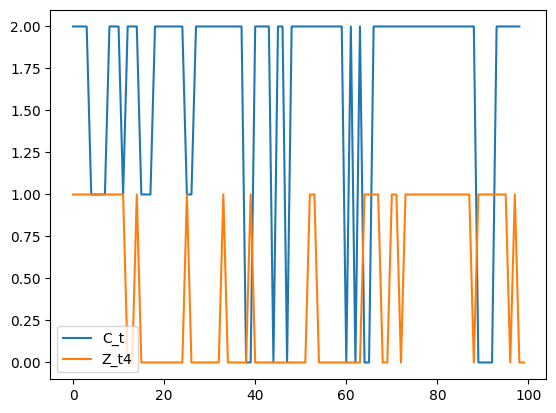

In [92]:
plt.plot(C_infer, label = "C_t") 
plt.plot([Z[i][5] for i in range(100)], label = "Z_t4")
plt.legend() 
plt.show()

# Learning

Suppose first that all variables, C_1, . . . ,C_T , Z and X are observed. Implement learning of the parameters:

In [154]:
n = 10
T = 100
C, Z, X = sim(n,T)

In [161]:
def learn_par(C,Z,X, Print = False):
    n = X.shape[1]
    T = X.shape[0]

    # Estimating lambda's
    lambda1 = sum(sum((Z[t] * X[t,:] for t in range(T)))) / (sum(sum(Z)))
    lambda0 = sum(sum(((np.ones(shape = n)-Z[t]) * X[t,:] for t in range(T)))) / (n*T - sum(sum(Z)))

    # Indicator functions of C 
    C_0 = [C[t] == 0 for t in range(T)]
    C_1 = [C[t] == 1 for t in range(T)]
    C_2 = [C[t] == 2 for t in range(T)]

    # Estimating alpha_hat
    if (sum(C_1) > 0):
        sum1 = sum(sum(Z[t][i] * C_1[t] for i in range(n)) for t in range(T)) / (2 * sum(C_1) * n)
    else:
        sum1 = 0
    if (sum(C_0) > 0):
        sum2 = sum(sum((1-Z[t][i]) * C_0[t] for i in range(n)) for t in range(T)) / (2 * sum(C_0) * n)
    else:
        sum2 = 0
    alpha_hat = sum1 + sum2

    # Estimating beta hat
    beta_hat = sum((C_0[t+1] + C_1[t+1])*C_2[t] for t in range(T-1)) / (sum(C_2[0:T-1]))

    # Estimating gamma hat
    gamma_hat = sum((C_2[t+1])*(C_1[t]+C_0[t]) for t in range(T-1)) / (sum(C_1[0:T-1]+ C_0[0:T-1]))

    if (Print == True):
        print("lambda0_hat is: ", lambda0, "\nlambda1_hat is: ", lambda1, "\nalpha_hat is:", alpha_hat, "\nbeta_hat is: ", beta_hat, "\ngamme_hat is: ", gamma_hat)
    
    return lambda0,lambda1, alpha_hat, beta_hat, gamma_hat

In [162]:
learn_par(C,Z,X, Print = True)

lambda0_hat is:  1.017001545595054 
lambda1_hat is:  5.050991501416431 
alpha_hat is: 0.9215447154471545 
beta_hat is:  0.10909090909090909 
gamme_hat is:  0.13636363636363635


(1.017001545595054,
 5.050991501416431,
 0.9215447154471545,
 0.10909090909090909,
 0.13636363636363635)

## Test the implementation using simulated data

In [163]:
n1 = 1000
n2 = 10
T = 100

np.random.seed(42)

C, Z, X = np.empty(shape=(n1,T)), np.empty(shape=(n1,T,n2)), np.empty(shape=(n1,T,n2))

for i in range(n1):
    C[i], Z[i], X[i] = sim(n2,T)

In [168]:
par_estimates = np.empty(shape =(n1,5))

for i in range(n1):
    par_estimates[i,:] = learn_par(C[i,:],Z[i,:,:],X[i,:,:])

In [188]:
names = ["lambda0", "lambda1", "alpha", "beta", "gamma"]
true_vals = [lambda_p[0], lambda_p[1], alpha, beta, gamma]

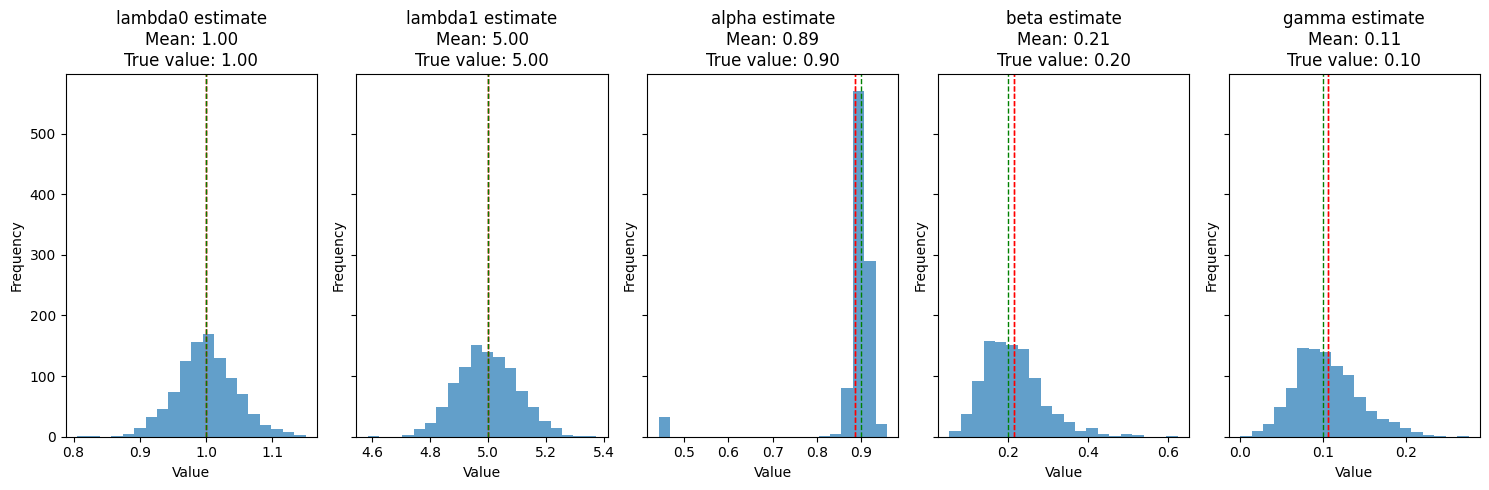

In [191]:
# Create subplots with 1 row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)

# Iterate through each subplot
for i, ax in enumerate(axes):
    # Plot histogram
    ax.hist(par_estimates[:,i], bins=20, alpha=0.7)
    
    # Calculate mean
    mean_value = np.mean(par_estimates[:,i])
    
    # Add vertical line for the mean
    ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)

    # Add vertical line for the mean
    ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)

    # Add vertical line for true value
    ax.axvline(true_vals[i], color='green', linestyle='dashed', linewidth=1)
    
    # Set title
    ax.set_title(f'{names[i]} estimate\nMean: {mean_value:.2f}\nTrue value: {true_vals[i]:.2f}')
    
    # Set labels
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Save plot
plt.savefig('histograms_with_means.png')

# Show plot
plt.show()